In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
import cartopy.crs as ccrs
import cartopy
import netCDF4 as nc 
import pickle
from matplotlib import gridspec
import os


In [2]:
def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    # m.shadedrelief(scale=scale)
    m.drawlsmask(land_color='gray',ocean_color='white',lakes=True)
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

def mask_observations(observations, inversion):
    new_inversion = np.copy(inversion)
    for i in range(len(observations)):
        for j in range(len(observations[0])):
            if np.isnan(observations[i][j]):
                new_inversion[i][j] = np.nan
    return new_inversion


def mask_high_error(stddev, inversion):
    new_inversion = np.copy(inversion)
    for i in range(len(stddev)):
        for j in range(len(stddev[0])):
            if stddev[i][j] >= inversion[i][j]*(20/100):
                new_inversion[i][j] = np.nan
    return new_inversion


def mask_sie(sie_map, inversion):
    new_inversion = np.copy(inversion)
    for i in range(len(sie_map)):
        for j in range(len(sie_map[0])):
            if not np.isnan(sie_map[i][j]) and sie_map[i][j] < 0.7:
                new_inversion[i][j] = np.nan
    return new_inversion


def pearson(inverse, OIB):
    # pearson coefficient
    ydata = np.array(inverse)
    yfit = np.array(OIB)

    ydata_mean = np.mean(ydata)
    yfit_mean = np.mean(yfit)

    data_diff = ydata - ydata_mean
    fit_diff = yfit - yfit_mean

    top = np.sum( (data_diff) * (fit_diff) )

    bottom = np.sqrt( np.sum(data_diff**2) * np.sum(fit_diff**2) )

    r = top/bottom

    return r

def analyse (calculated_data, validation_data):
    error = np.array(calculated_data) - np.array(validation_data)
    md = np.mean(error)
    rmse = np.sqrt( np.mean( (error)**2 ))
    residuals = error**2
    denom = (calculated_data - np.mean(calculated_data)) ** 2
    r2 = 1 - (np.sum(residuals) / np.sum(denom))

    # Calculate slope and y-intercept
    slope, intercept = np.polyfit(validation_data, calculated_data, 1)

    return md, rmse, r2, slope, intercept


In [3]:
def ice_OIB(OIB_files):

    SIT_OIB = nc.Dataset(OIB_files).variables['Sea Ice Thickness'][:,:]
    return SIT_OIB

In [4]:
## Validation against OIB

OIB_files = ["/home/erb/masterproject/MSCI_project/validation_data/OIB_data/OIB_201904/20190408.nc",
             "/home/erb/masterproject/MSCI_project/validation_data/OIB_data/OIB_201904/20190412.nc",
             "/home/erb/masterproject/MSCI_project/validation_data/OIB_data/OIB_201904/20190419.nc",
             "/home/erb/masterproject/MSCI_project/validation_data/OIB_data/OIB_201904/20190420.nc",
             "/home/erb/masterproject/MSCI_project/validation_data/OIB_data/OIB_201904/20190422.nc"]

awismos_file = ['/home/erb/masterproject/MSCI_project/validation_data/AWI/2.6_AWI_data/2019/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201904-fv2p6.nc']

awismos = nc.Dataset(awismos_file[0])
awismos.variables.keys()
SIT_awismos = awismos.variables['sea_ice_thickness'][0][36:396,36:396][::-1, :]

lon_g = np.load("/home/erb/masterproject/MSCI_project/new_lon_25km.npy")
lat_g = np.load("/home/erb/masterproject/MSCI_project/new_lat_25km.npy")

sie_path = '/home/erb/masterproject/MSCI_project/snow_ice/carmen/SIE/SIE_masking_25km_2018-2019_season.pkl'
f = open(sie_path,'rb')
sie_file = pickle.load(f)
sie_map  = sie_file['20190415']

OIB_array = []
for i in range(len(OIB_files)):
    OIB_array.append(nc.Dataset(OIB_files[i]).variables['Sea Ice Thickness'][:,:])

In [5]:
SIT_OIB, SIT_OIB_2 = [], []
ice_inverse = []
ice_awismos = []


for i in range(len(OIB_files)):
    
    file_OIB = ice_OIB(OIB_files[i])
    inverse_ice_data = np.load('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201904/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_ice.npy')
    inverse_ice_stddev = np.load('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201904/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_ice_stddev.npy')

    inverse_ice_data = mask_high_error(inverse_ice_stddev, inverse_ice_data)
    inverse_ice_data = mask_sie(sie_map, inverse_ice_data)

    for k in range(360):
        for j in range(360):
            if not (file_OIB.mask[k][j]) and not np.isnan(inverse_ice_data[k][j]):
                ice_inverse.append(inverse_ice_data[k][j])
                SIT_OIB.append(file_OIB[k][j])


for i in range(len(OIB_files)):
    
    file_OIB = ice_OIB(OIB_files[i])

    for k in range(360):
        for j in range(360):
            if not (file_OIB.mask[k][j]) and not np.isnan(SIT_awismos[k][j]):
                ice_awismos.append(SIT_awismos[k][j])
                SIT_OIB_2.append(file_OIB[k][j])

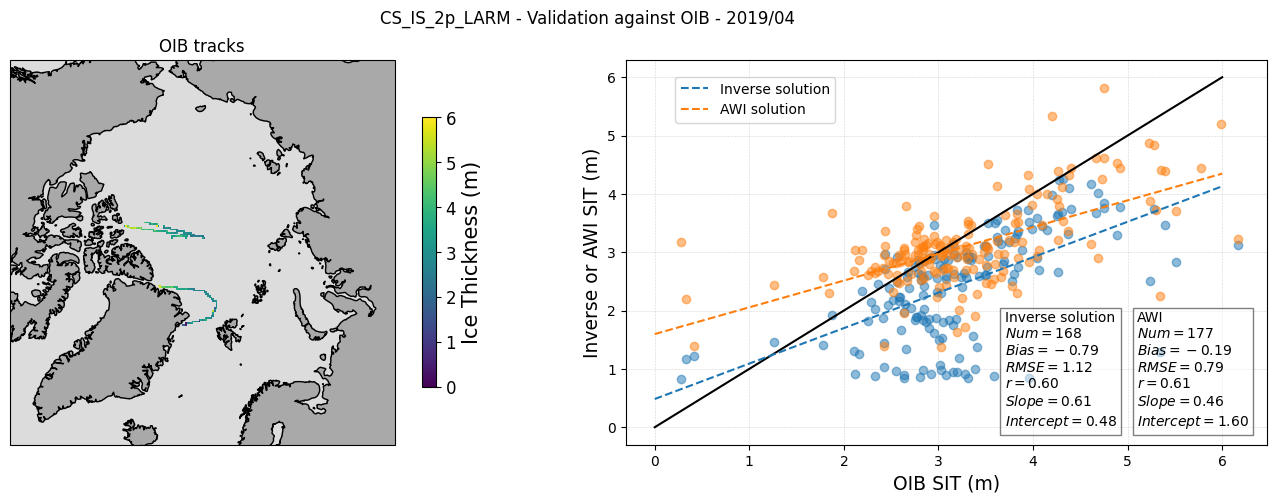

In [7]:
fig = plt.figure(figsize = (17,5))
spec = gridspec.GridSpec(ncols=2, nrows=1,wspace=0.2, height_ratios=[1], width_ratios=[1.3, 1.5])

plt.rcParams['text.usetex'] = False
plt.suptitle('CS_IS_2p_LARM - Validation against OIB - 2019/04')



ax1 = fig.add_subplot(spec[0], projection=ccrs.NorthPolarStereo())
ax1.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=0)
ax1.add_feature(cartopy.feature.OCEAN, color='gainsboro', edgecolor='black')
ax1.coastlines()
ax1.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
p_map = ax1.pcolormesh(lon_g,lat_g, OIB_array[0],cmap='viridis',alpha=1.0, transform=ccrs.PlateCarree(), vmin = 0, vmax = 6)
p_map = ax1.pcolormesh(lon_g,lat_g, OIB_array[1],cmap='viridis',alpha=1.0, transform=ccrs.PlateCarree(), vmin = 0, vmax = 6)
p_map = ax1.pcolormesh(lon_g,lat_g, OIB_array[2],cmap='viridis',alpha=1.0, transform=ccrs.PlateCarree(), vmin = 0, vmax = 6)
p_map = ax1.pcolormesh(lon_g,lat_g, OIB_array[3],cmap='viridis',alpha=1.0, transform=ccrs.PlateCarree(), vmin = 0, vmax = 6)
p_map = ax1.pcolormesh(lon_g,lat_g, OIB_array[4],cmap='viridis',alpha=1.0, transform=ccrs.PlateCarree(), vmin = 0, vmax = 6)
plt.title('OIB tracks')
a = fig.colorbar(p_map,shrink=0.7, pad=0.05, orientation = 'vertical')
a.ax.tick_params(labelsize=12)
a.set_label('Ice Thickness (m)',fontsize=15)


ax2 = fig.add_subplot(spec[1])
ax2.scatter(SIT_OIB, ice_inverse, alpha = 0.5)
ax2.scatter(SIT_OIB_2, ice_awismos, alpha = 0.5)
ax2.plot([0,6] , [0,6], 'k-')
ax2.grid(linestyle='dotted', linewidth ='0.4')
ax2.set_xlabel('OIB SIT (m)', fontsize = 13.5)
ax2.set_ylabel('Inverse or AWI SIT (m)', fontsize = 13.5)

md_snow_inverse, rmse_snow_inverse, r2_snow_inverse, slope, intercept = analyse(ice_inverse, SIT_OIB)
r_snow = pearson(SIT_OIB, ice_inverse)

textstr = '\n'.join((
    rf'Inverse solution',
    rf'$Num = {len(ice_inverse)}$',
    rf'$Bias={md_snow_inverse:.2f}$',
    rf'$RMSE={rmse_snow_inverse:.2f}$',
    rf'$r = {r_snow:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
ax2.text(3.7, 2, textstr, bbox=box_props, verticalalignment='top')

x_values = np.array([0,6])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, '--', label = 'Inverse solution')


md_snow_inverse, rmse_snow_inverse, r2_snow_inverse, slope, intercept = analyse(ice_awismos, SIT_OIB_2)
r_snow = pearson(SIT_OIB_2, ice_awismos)

textstr = '\n'.join((
    rf'AWI',
    rf'$Num = {len(ice_awismos)}$',
    rf'$Bias={md_snow_inverse:.2f}$',
    rf'$RMSE={rmse_snow_inverse:.2f}$',
    rf'$r = {r_snow:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
ax2.text(5.1, 2, textstr, bbox=box_props, verticalalignment='top')

# Regression line
x_values = np.array([0,6])
y_values = slope * x_values + intercept
ax2.plot(x_values, y_values, '--', label = "AWI solution")

fig.legend(loc = "upper right",bbox_to_anchor=(0.65, 0.86))

save_fig = 1
if save_fig == 1 :
    plt.savefig('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation_oib_ice_csis2p_delaunay.png', dpi = 300)
